# **Bioinformatics Application in Drug Discovery**
---

## **Part 0: Introduction of Google colab**

**What is Colaboratory?**

Colaboratory, or “Colab” for short, is a product from Google Research. Colab allows anybody to **write and execute arbitrary python code through the browser**, and is especially well suited to machine learning, data analysis and education. More technically, Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs.

For more information -> (https://research.google.com/colaboratory/faq.html)

---

## **Part 1: Data Collection**

To build the machine learning for drug discovery, we need to collect data from the ChEMBL database first.

**ChEMBL** is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs. 

For more information -> https://www.ebi.ac.uk/chembl/

---



### **1.1) Installing and importing the libraries**

In [ ]:
#check version of Python
!python --version

In [ ]:
#pip is the package installer for Python
! pip install chembl_webresource_client

In [ ]:
#Pandas DataFrame is a 2-dimensional labeled data structure like any table with rows and columns.
#For more information -> https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
import pandas as pd
from chembl_webresource_client.new_client import new_client

### **1.2) Searching for targeted protien**

In this demonstration, we will focus on **acetylcholinesterase**, one of the molecule of the month in PDB-101 website (https://pdb101.rcsb.org/motm/54). Acetylcholinesterase stops the signal between a nerve cell and a muscle cell. This means *every time you move a muscle and every time you think a thought, your nerve cells are hard at work*. It is a highly viable target for the symptomatic improvement in Alzheimer's disease. 

In [ ]:
# Target search -> acetylcholinesterase
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
targets

### **1.3) Select and retrieve bioactivity data for Human Acetylcholinesterase [DF1]**

In [ ]:
#select the target in Homo sapiens
selected_target = targets.target_chembl_id[0]
selected_target

In [ ]:
#retrieve bioactivity focusing on IC50
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
#pandas.DataFrame.from_dict -> Creates DataFrame object from dictionary by columns or by index allowing dtype specification.
df = pd.DataFrame.from_dict(res)

In [ ]:
#show DataFrame
df

In [ ]:
#export CSV data file
df.to_csv('acetylcholinesterase_01_bioactivity_data_raw.csv', index=False)

### **1.4) Dealing with missing value [DF2]**



In [ ]:
#drop compounds without the standard_value and canonical_smiles 
#The standard_value -> IC50
#Canonical_smiles -> Simplified Molecular Input Line Entry Specification (canonical format)
#DataFrame.notna() -> Detect existing (non-missing) values.
#Detect existing (non-missing) values. 
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2 = df2.loc[df2['standard_value'] > 0]
df2

In [ ]:
df2.standard_value.describe()

In [ ]:
#len -> Return the number of items in a list
len(df2.canonical_smiles.unique())

In [ ]:
#remove the duplicate SMILES
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr  

### **1.5) Data pre-processing of the bioactivity data [DF3]**

In [ ]:
#Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

In [ ]:
df3.to_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv', index=False)

### **1.6) Labeling compounds [DF4 and DF5]**
From IC50 value, we can seperate compounds into three groups active (less than 1,000 nM), inactive (greater than 10,000 nM) or intermediate (1,000 - 10,000 nM) 


In [ ]:
#pd.read_csv -> Read a comma-separated values (csv) file into DataFrame.
df4 = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [ ]:
#condition for seperation of active, inactive and intermediate compounds 
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
#pandas.concat -> Can also add a layer of hierarchical indexing on the concatenation axis, which may be useful if the labels are the same (or overlapping) on the passed axis number.
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

In [ ]:
df5.to_csv('acetylcholinesterase_03_bioactivity_data_curated.csv', index=False)

In [ ]:
! zip acetylcholinesterase.zip *.csv

In [ ]:
! ls -l

## **Part 2: Exploratory Data**

In this part, we will perform Descriptor Calculation and Exploratory Data Analysis.

*Note that molecular descriptors are widely employed to present molecular characteristics in cheminformatics.



### **2.1) Installing conda and rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

### **2.2) Clean Smiles**

In [ ]:
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')
df

In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

### **2.3) Calculate Lipinski descriptors**

***Christopher Lipinski***, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

*   Molecular weight < 500 Dalton
*   Octanol-water partition coefficient (LogP) < 5
*   Hydrogen bond donors < 5
*   Hydrogen bond acceptors < 10

[Reference: DataProfessor]

In [ ]:
#import libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
#calculate the descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

### **2.4) Combine DataFrame**

In [ ]:
# combine df with df_lipinski
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

### **2.5) Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **pIC50 = -log10(IC50)**.

This custom function **pIC50()** will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

Note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_combined.standard_value.describe()

In [ ]:
-np.log10( (10**-9)* 100000000 )

In [ ]:
-np.log10( (10**-9)* 10000000000 )

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)
    
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_final = pIC50(df_norm)
df_final

In [ ]:
df_final.pIC50.describe()

In [ ]:
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

### **2.6) Remove intermediate**

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

In [ ]:
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

### **2.7) Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

#### **Frequency plot of the 2 bioactivity classes**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

#### **Scatter plot of MW versus LogP**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

#### **Box Plost - pIC50 value**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

#### **Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

#### **MW**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

#### **LogP**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

#### **NumHDonors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

#### **NumHAcceptors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

---

#### **Interpretation***
**pIC50 values**
Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

**Lipinski's descriptors**
All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives.

---

## **Part 3: Descriptor Calculation**

In this part, we will calculate molecular descriptors that are essentially quantitative description of the compounds in the dataset.



### **3.1) Download PaDEL-Descriptor**

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
! unzip padel.zip

### **3.2) Load bioactivity data**

In [ ]:
df3 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
df3

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

In [ ]:
! cat molecule.smi | wc -l

### **3.3) Calculate fingerprint descriptors - PaDEL descriptors**

In [ ]:
! cat padel.sh

In [ ]:
! bash padel.sh

### **3.4) Preparing the X and Y Data Matrices**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X

In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

In [ ]:
df3_Y = df3['pIC50']
df3_Y

In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

In [ ]:
dataset3.to_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

## **Part 4: Model Building**

In this part, we will build a regression model of acetylcholinesterase inhibitors using the random forest algorithm.



### **4.1) Import libraries**

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### **4.2) Load data set**

In [ ]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

### **4.3) Input features**

In [ ]:
#input features
X = df.drop('pIC50', axis=1)
X

In [ ]:
#Output features
Y = df.pIC50
Y

In [ ]:
X.shape

(5904, 881)

In [ ]:
Y.shape

### **4.4) Remove low variance features**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [ ]:
X.shape

### **4.5) Data split (80/20 ratio)**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_test.shape, Y_test.shape

### **4.6) Building a Regression Model using Random Forest**##

In [ ]:
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
Y_test

In [ ]:
Y_pred

### **4.7) Scatter Plot of Experimental vs Predicted pIC50 Values**##

<function matplotlib.pyplot.show(close=None, block=None)>

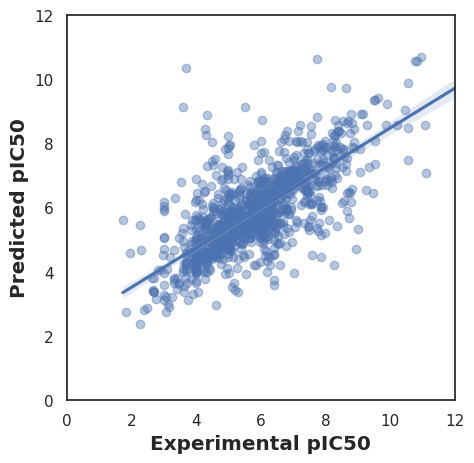

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=Y_test,y=Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## **Part 5: Model Comparison**

In this part, we will compare several ML algorithms for build regression models of acetylcholinesterase inhibitors.



### **5.1) Import libraries**##

In [ ]:
! pip install lazypredict

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

### **5.2) Load data set**

In [ ]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

In [ ]:
X = df.drop('pIC50', axis=1)
Y = df.pIC50

### **5.3) Data pre-processing**

In [ ]:
# Examine X dimension
X.shape

In [ ]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

In [ ]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### **5.4) Compare ML algorithms**

In [ ]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

NameError: ignored

In [ ]:
# Performance table of the training set (80% subset)
predictions_train

In [ ]:
# Performance table of the test set (20% subset)
predictions_test

### **5.5) Data visualization of model performance**

In [ ]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

In [ ]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

In [ ]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))